In [19]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers, models, layers
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
tf.keras.backend.clear_session()

gpus = tf.config.list_physical_devices('GPU')

if gpus:
    print("TensorFlow is using the GPU \n", gpus)
else:
    print("No GPU detected.")

TensorFlow is using the GPU 
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import wandb 

from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Carga de los datos

ds = pd.read_csv("/global_house_purchase_dataset.csv")
ds.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


## Análisis exploratorio de los datos

In [5]:
print("NaN values: \n \n ", ds.isna().sum(),
      "\n \n Types: \n \n", ds.dtypes)

NaN values: 
 
  property_id                0
country                    0
city                       0
property_type              0
furnishing_status          0
property_size_sqft         0
price                      0
constructed_year           0
previous_owners            0
rooms                      0
bathrooms                  0
garage                     0
garden                     0
crime_cases_reported       0
legal_cases_on_property    0
customer_salary            0
loan_amount                0
loan_tenure_years          0
monthly_expenses           0
down_payment               0
emi_to_income_ratio        0
satisfaction_score         0
neighbourhood_rating       0
connectivity_score         0
decision                   0
dtype: int64 
 
 Types: 
 
 property_id                  int64
country                     object
city                        object
property_type               object
furnishing_status           object
property_size_sqft           int64
price               

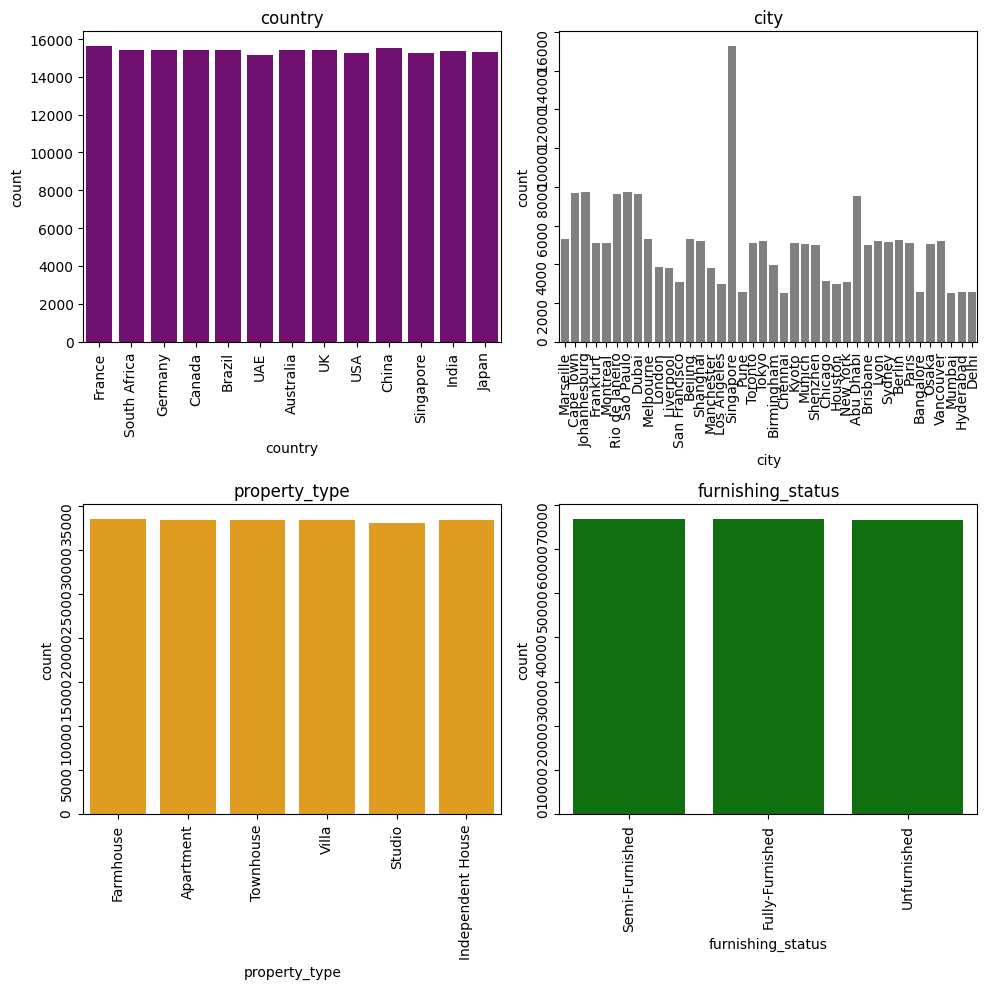

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (10,10))
axes = axes.flatten()

sns.countplot(ds, x = "country", color = "purple", ax = axes[0])
axes[0].tick_params(axis="x", rotation=90)
axes[0].set_title("country")

sns.countplot(ds, x = "city", color = "grey", ax = axes[1])
axes[1].tick_params(rotation = 90)
axes[1].set_title("city")

sns.countplot(ds, x = "property_type", color = "orange", ax = axes[2])
axes[2].tick_params(rotation = 90)
axes[2].set_title("property_type")

sns.countplot(ds, x = "furnishing_status", color = "green", ax = axes[3])
axes[3].tick_params(rotation = 90)
axes[3].set_title("furnishing_status")

plt.tight_layout()
plt.show() 

In [7]:
# One hot encoding

ds = pd.get_dummies(ds, columns = ["country", "city", "property_type", "furnishing_status"],
                            drop_first = False)
ds.drop("property_id", axis = 1, inplace = True)
ds = ds.astype("float32")

# ds.head()

In [8]:
# Separación de los datos

x = ds.drop("decision", axis=1)
y = ds["decision"] 

from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.3, random_state = 5)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 1/3, random_state = 5)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 140000
Validation size: 40000
Test size: 20000


In [9]:
# Estandarización de los datos

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

## Creación del modelo

In [10]:
wandb.init(
    project="Global-House-Purchase-Decision-ANN-Model-1",
    name = "Entramiento 2",
    config={
        "Layer1": 108,
        "Activation_1": "sigmoid",
        "Dropout1": 0.0,
        "Layer2": 73,
        "Activation_2": "relu",
        "Dropout2": 0.0,
        "Layer3": 34,
        "Actiavtion_3": "sigmoid",
        "Optimizer": "adam",
        "Metric": "accuracy",
        "Epochs": 32,
        "Batch_size": 100,
        "Eta": 0.00014359104323874677,
        "Regularizer": "L1L2",
        "L1": 0.00001508797241665705,
        "L2": 0.00000324211243183006,
        "Loss": "binary_crossentropy"
    }
)

In [11]:
model = models.Sequential()
model.add(layers.Dense(108, activation = "sigmoid",
                       input_shape = (X_train.shape[1],)))
model.add(layers.Dense(73, activation = "relu",
                      kernel_regularizer = tf.keras.regularizers.L1L2(0.00001508797241665705,0.00000324211243183006)))
model.add(layers.Dense(1, activation = "sigmoid"))

model.compile(optimizer = Adam(0.00014359104323874677), loss = "binary_crossentropy",
             metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 108)               8856      
                                                                 
 dense_1 (Dense)             (None, 73)                7957      
                                                                 
 dense_2 (Dense)             (None, 1)                 74        
                                                                 
Total params: 16,887
Trainable params: 16,887
Non-trainable params: 0
_________________________________________________________________


In [12]:
history = model.fit(
        X_train, y_train,
        validation_data = (X_test, y_test),
        epochs = 30,
        batch_size = 40,
        verbose = 1, 
        callbacks = [WandbMetricsLogger(log_freq=5)]
    )

Epoch 1/30
3500/3500 [==============================] - 6s 2ms/step - loss: 0.2390 - accuracy: 0.9014 - val_loss: 0.1442 - val_accuracy: 0.9410
Epoch 2/30
3500/3500 [==============================] - 5s 1ms/step - loss: 0.1387 - accuracy: 0.9436 - val_loss: 0.1356 - val_accuracy: 0.9448
Epoch 3/30
3500/3500 [==============================] - 5s 2ms/step - loss: 0.1294 - accuracy: 0.9474 - val_loss: 0.1200 - val_accuracy: 0.9513
Epoch 4/30
3500/3500 [==============================] - 5s 1ms/step - loss: 0.1054 - accuracy: 0.9604 - val_loss: 0.0898 - val_accuracy: 0.9718
Epoch 5/30
3500/3500 [==============================] - 6s 2ms/step - loss: 0.0774 - accuracy: 0.9777 - val_loss: 0.0676 - val_accuracy: 0.9825
Epoch 6/30
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0578 - accuracy: 0.9858 - val_loss: 0.0495 - val_accuracy: 0.9880
Epoch 7/30
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0403 - accuracy: 0.9914 - val_loss: 0.0353 - val_accuracy:

In [13]:
wandb.finish()

batch/accuracy,▁▁▁▁▁▅▆▆▆▇▇█████████████████████████████
batch/batch_step,▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▄▅▆▇▇███████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▂▅▆▇▇███████████████████████
epoch/val_loss,██▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99946


In [14]:
# Se guarda el modelo
model.save("model_f.h5")

## Evaluación del modelo

In [28]:
model_ev = keras.models.load_model("model_f.h5")

In [29]:
# Evaluación del modelo

loss, accuracy = model_ev.evaluate(X_val, y_val, verbose=1)

print(f"Test Loss: {loss:}")
print(f"Test Accuracy: {accuracy:}")


1250/1250 [==============================] - 1s 902us/step - loss: 0.0063 - accuracy: 0.9988
Test Loss: 0.006262289825826883
Test Accuracy: 0.9988250136375427


1250/1250 [==============================] - 1s 608us/step


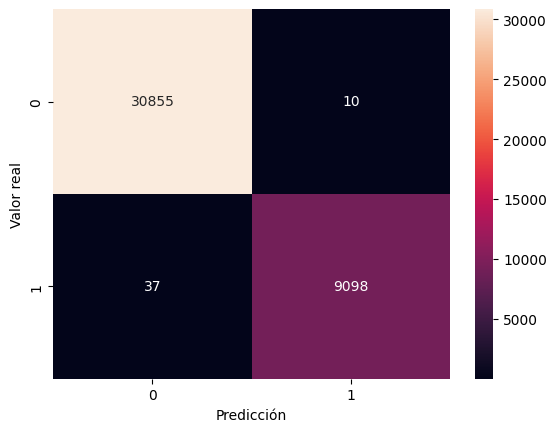

In [33]:
import seaborn as sns

y_pred = model_ev.predict(X_val)
y_pred_classes = (y_pred > 0.5).astype("int32")

cm = confusion_matrix(y_val, y_pred_classes)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "rocket")

plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.show()

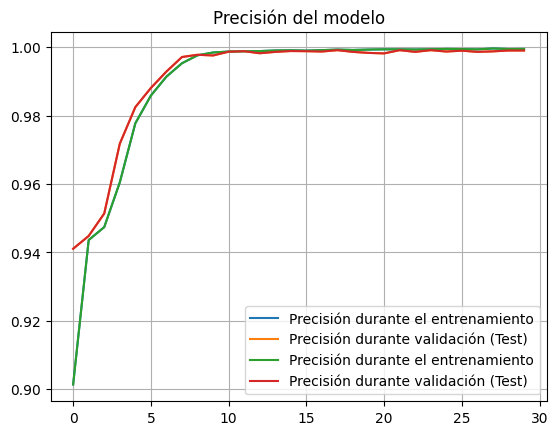

In [38]:
plt.plot(history.history["accuracy"], label = "Precisión durante el entrenamiento")
plt.plot(history.history["val_accuracy"], label="Precisión durante validación (Test)")
plt.title("Precisión del modelo")

plt.grid()
plt.legend()
plt.show()

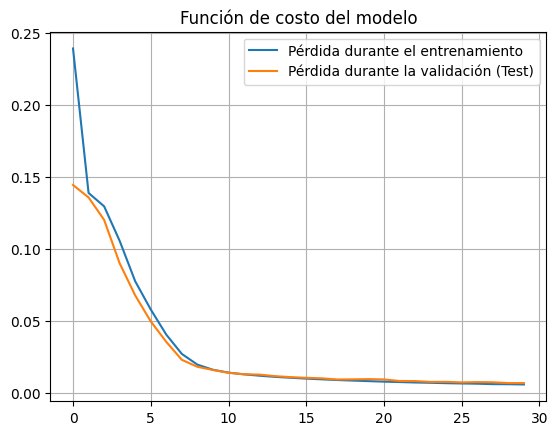

In [39]:
plt.plot(history.history["loss"], label = "Pérdida durante el entrenamiento")
plt.plot(history.history["val_loss"], label = "Pérdida durante la validación (Test)")
plt.title("Función de costo del modelo")

plt.grid()
plt.legend()
plt.show()